Alright bhai, let me explain this in more detail, step by step, so that it makes sense.

---

### **Parent Document Retriever: The Detailed Explanation**

Parent Document Retrievers solve a key problem in RAG (Retrieval-Augmented Generation):  
How do we balance **specificity** (retrieving highly relevant small chunks) with **contextual richness** (providing enough information for the LLM to answer accurately)?

Let’s break this down.

---

### **The Problem**
In traditional RAG workflows:
1. You split large documents into smaller chunks for indexing.
2. Each chunk gets an embedding—a vector that captures its meaning.
3. When a query is asked, the retriever searches these embeddings for the most relevant chunks and sends them to the LLM.

But there’s a tradeoff:
- **Big chunks:** Provide better context but lead to "washed out" embeddings (less specific).
- **Small chunks:** Improve specificity but lack sufficient context, making it harder for the LLM to reason effectively.

For example:
- If a document discusses earnings, ads revenue, and Bard revenue in one section, a single embedding for the whole section might generalize as "earnings data," losing specificity.
- Smaller chunks (e.g., just ads revenue or just Bard revenue) give precise embeddings, but without the larger context, comparisons between the two may be missed.

---

### **Solution: Parent Document Retriever**
This approach creates a **hierarchy** of documents—parent and child:
1. **Parent Documents:** Medium-sized chunks that preserve overall context.
2. **Child Documents:** Fine-grained smaller chunks derived from parent documents for precise embeddings.

The workflow looks like this:
1. Split the original documents into **parent chunks** (e.g., 2000 characters each).
2. Further split each parent chunk into **child documents** (e.g., 400 characters each).
3. Generate embeddings for child documents (smaller size = more specific).
4. At query time:
   - Match the query against child embeddings for specificity.
   - Return the parent document for the broader context.

---

### **Why This Works**
- **Specificity from child embeddings:** Matches are precise because the embeddings represent small, focused parts of the document.
- **Context from parent documents:** The LLM receives the larger parent document, giving it enough information to make connections and generate coherent responses.

This method is ideal for scenarios where:
- Detailed information (like product features or financial data) is scattered across large documents.
- LLMs need enough context for comparisons or reasoning.

---

### **Two Ways to Use Parent Document Retrievers**
1. **Return Full Documents:**
   - If the original documents are small (e.g., short blog posts or product descriptions), you can treat each as a "parent document."
   - After splitting into child chunks for embeddings, retrieval brings back the **entire original document.**
   - Works well for datasets with many small but self-contained documents.

2. **Return Larger Chunks:**
   - For longer documents (e.g., multi-page reports), you retrieve **parent chunks** instead of full documents.
   - Parent chunks are big enough for context but smaller than the full document, avoiding token limit issues.

---

### **Implementation Walkthrough (LangChain Example)**
#### **1. Setup**
- Documents: The example uses scraped LangChain blog posts saved as text files.
- Embeddings: Uses **BGE embeddings** (smaller and faster than OpenAI embeddings).

#### **2. Splitting**
- **Child splitter:** Divides parent chunks into smaller parts (e.g., 400 characters).
- **Parent splitter:** Divides documents into medium-sized chunks (e.g., 2000 characters).

#### **3. Retrieval Process**
- **Child embeddings:** Queries match these for precise retrieval.
- **Parent retrieval:** After finding relevant child chunks, their parent chunks are returned for broader context.

#### **4. Example Workflow**
- Query: *"What is LangSmith?"*
  - Matches child embeddings for accuracy.
  - Returns the parent chunk for context (e.g., a larger portion of the blog post discussing LangSmith).

---

### **Benefits**
- **Fine-Grained Precision:** Child embeddings ensure highly specific matches.
- **Rich Context:** Parent documents provide the LLM with enough information for comparisons and reasoning.
- **Flexible for Long or Short Texts:** Can adapt to datasets with varying document sizes.

---

### **When to Use It**
Parent Document Retrievers are great for:
1. **Large Documents:** Research papers, earnings reports, or manuals where detailed information is spread across sections.
2. **Product Comparisons:** When LLMs need to analyze and compare multiple pieces of information.
3. **Dense Contexts:** Any use case requiring both detailed embeddings and broader context for coherence.

---

**Clear now, bhai? If you have any specific doubts, let me know!** 😊

# Most general or basic RAG uses like :

![Sam Witteveen - Advanced RAG 02 - Parent Document Retriever [wQEl0GGxPcM - 793x446 - 3m12s].png](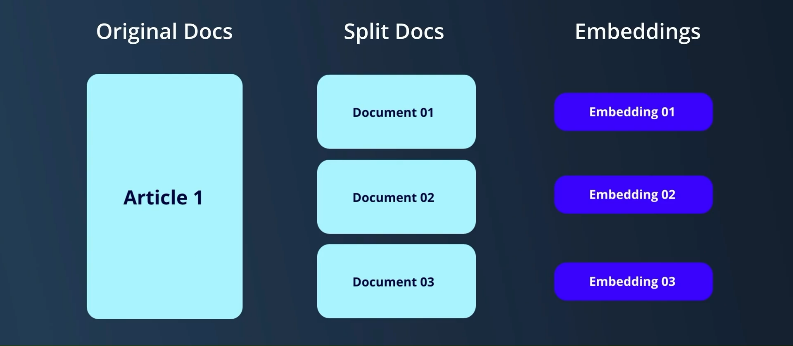)

But if the 3 documents are too big or large then the specificity of context or specificity in embedding will be lost.

"Each of the three embeddings are the semantic representation of the all the semantic details that are in that particular document. If that particular split doc is quite big, then the embedding can get very washy. Embedding can be non-specific. So embedding will be more general about some information."

"Whereas if that chunk is quite small, the embedding can be very specific." But without information from the bigger chunk or overall context, the llm would not be able to generate clear answers, for particular question, which is highly specifically matches in the smaller chunks."

So in advanced RAG with parent document retrieval, we uses both the child chunk(very specific to match exact question) then get the corresponding parent chunk(contains general information related to that child chunk), and fianlly the LLM uses the highly specific smaller child embedding as well as general parent emebdding for that child to generate final response.


![Sam Witteveen - Advanced RAG 02 - Parent Document Retriever [wQEl0GGxPcM - 793x446 - 3m52s].png](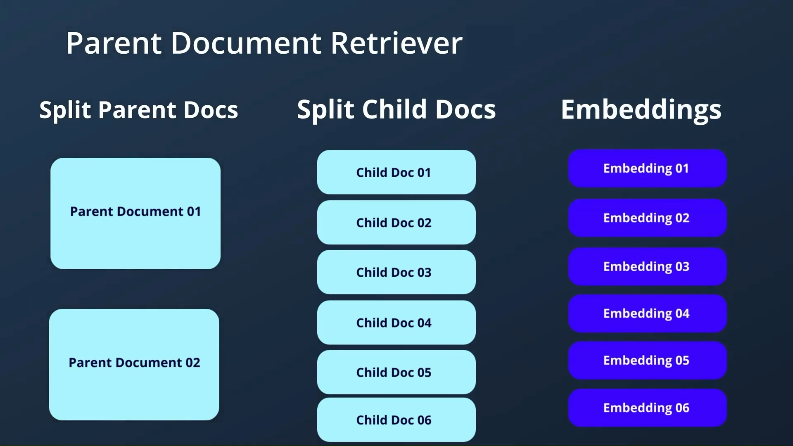)

![Sam Witteveen - Advanced RAG 02 - Parent Document Retriever [wQEl0GGxPcM - 793x446 - 4m45s].png](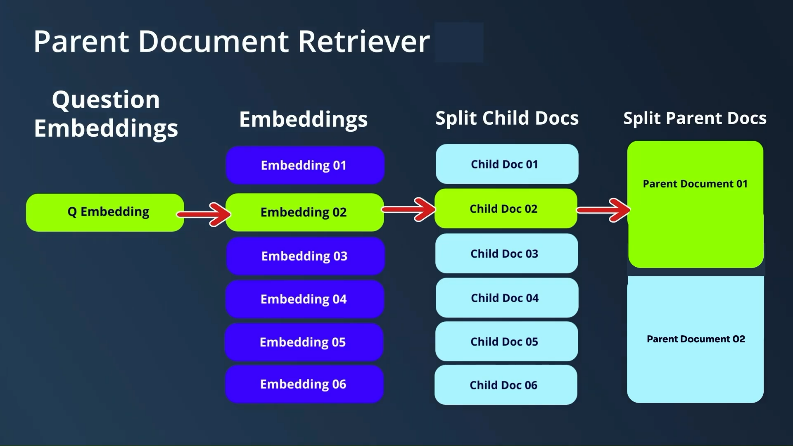)

LLM can take advantage of both highly specific query matching with smaller child chunk + general details regarding the context of the query from the bigger parent chunk; to generate its response.

# let's see how we can do this in langchain

In [1]:
!pip -q install langchain openai tiktoken chromadb lark
!pip -q install sentence_transformers
!pip -q install -U FlagEmbedding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.9 MB/s eta 0:00:0

In [10]:
!rm -rf blog_posts/

In [11]:
# https://www.dropbox.com/scl/fi/ulbt145sthizf2nazey49/langchain_blog_posts.zip?rlkey=9unhw0vukhlwacahmpnk5m591&dl=0

!mkdir -p blog_posts
!unzip -q /content/langchain_blog_posts.zip -d blog_posts

## Parent Document Retriever

2 ways to use it:

1. Return full docs from smaller chunks look up : if the full document/chunk is not that long.

2. Return bigger chunks for smaller chunks look up : This is parent document retrieval pipeline.

In [3]:
!pip install -qU "langchain-chroma>=0.1.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 14.5 MB/s eta 0:00:00


In [4]:
!pip install -qU langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.7 MB/s eta 0:00:00


In [5]:
from langchain.schema import Document
from langchain_chroma import Chroma
from langchain.retrievers import ParentDocumentRetriever

## Text Splitting & Docloader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain_community.document_loaders import TextLoader

# from langchain.embeddings.openai import OpenAIEmbeddings
# embeddings = OpenAIEmbeddings()

## BGE Embeddings

In [6]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-small-en-v1.5"
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

bge_embeddings = HuggingFaceBgeEmbeddings(
    model_name = model_name,
    model_kwargs = {'device': 'cuda'},
    encode_kwargs = encode_kwargs
)

<ipython-input-6-0034f8d26ade>:6: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  bge_embeddings = HuggingFaceBgeEmbeddings(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Data Prep

In [12]:
loaders = [
    TextLoader('/content/blog_posts/blog.langchain.dev_announcing-langsmith_.txt'),
    TextLoader('/content/blog_posts/blog.langchain.dev_benchmarking-question-answering-over-csv-data_.txt'),
]
docs = []
for l in loaders:
    docs.extend(l.load())

In [13]:
len(docs)

2

In [14]:
docs[0]

Document(metadata={'source': '/content/blog_posts/blog.langchain.dev_announcing-langsmith_.txt'}, page_content='URL: https://blog.langchain.dev/announcing-langsmith/\nTitle: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications\n\nLangChain exists to make it as easy as possible to develop LLM-powered applications.\n\nWe started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at addressing this and we see lots of tinkering happening now (Nat agrees)–people are building everything from chatbots over internal company documents to an AI dungeon master for a Dungeons and Dragons game.\n\nThe blocker has now changed. While it’s easy to build a prototype of an application in ~5 lines of LangChain code, it’

Each doc is one full blog post.

## 1. Retrieving full documents rather than chunks
In this mode, we want to retrieve the full documents.

This is good to use if you initial full docs aren't too big themselves and you aren't going to return many of them

In [15]:
# This text splitter is used to create the child documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)


# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name = "full_documents",
    embedding_function = bge_embeddings  #OpenAIEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()

full_doc_retriever = ParentDocumentRetriever(
    vectorstore = vectorstore,
    docstore = store,
    child_splitter = child_splitter,
)

In [16]:
full_doc_retriever.add_documents(docs, ids=None)

In [17]:
# our
list(store.yield_keys())

['a1f241a6-e1c5-44e7-8037-553443e2aa29',
 'eba687a6-4c24-400b-8d50-8c4e6bd8736d']

In [18]:
# vectorstore

In [19]:
sub_docs = vectorstore.similarity_search("what is langsmith", k=2) # child chunks se similarity_search

In [20]:
print(sub_docs[0].page_content)

Today, we’re introducing LangSmith, a platform to help developers close the gap between prototype and production. It’s designed for building and iterating on products that can harness the power–and wrangle the complexity–of LLMs.


In [21]:
retrieved_docs = full_doc_retriever.get_relevant_documents("what is langsmith") # full_docs are the parent chunks

<ipython-input-21-cb2819512abb>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = full_doc_retriever.get_relevant_documents("what is langsmith") # full_docs are the parent chunks


I am getting the matching fulldoc for the matched child

In [22]:
len(retrieved_docs[0].page_content)

11652

In [23]:
retrieved_docs[0].page_content

'URL: https://blog.langchain.dev/announcing-langsmith/\nTitle: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications\n\nLangChain exists to make it as easy as possible to develop LLM-powered applications.\n\nWe started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at addressing this and we see lots of tinkering happening now (Nat agrees)–people are building everything from chatbots over internal company documents to an AI dungeon master for a Dungeons and Dragons game.\n\nThe blocker has now changed. While it’s easy to build a prototype of an application in ~5 lines of LangChain code, it’s still deceptively hard to take an application from prototype to production. The main issue that we see today 

# 2. Retrieveing Larger Chunks:

Sometimes, the full documents can be too big to want to retrieve as is. In that case, what we really want to do is to first spilt the raw documents into larger chunks, and then split it into smaller chunks. We then index the smaller chunks, but on retrieval we retrieve the larger chunks (but still not the full documents)

In [24]:
# This text splitter is used to create the parent documents - The big chunks
parent_splitter = RecursiveCharacterTextSplitter(chunk_size = 2000)

# This text splitter is used to create the child documents - The small chunks
# It should create documents smaller than the parent
child_splitter = RecursiveCharacterTextSplitter(chunk_size = 400)

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name = "split_parents", embedding_function = bge_embeddings) #OpenAIEmbeddings()

# The storage layer for the parent documents
store = InMemoryStore()

In [25]:
big_chunks_retriever = ParentDocumentRetriever(
    vectorstore = vectorstore,
    docstore = store,
    child_splitter = child_splitter,
    parent_splitter = parent_splitter,
)

In [26]:
big_chunks_retriever.add_documents(docs)

In [27]:
len(list(store.yield_keys()))

18

In [28]:
sub_docs = vectorstore.similarity_search("what is langsmith")

In [29]:
len(sub_docs)

4

In [30]:
print(sub_docs[0].page_content)

Today, we’re introducing LangSmith, a platform to help developers close the gap between prototype and production. It’s designed for building and iterating on products that can harness the power–and wrangle the complexity–of LLMs.


In [31]:
retrieved_docs = big_chunks_retriever.get_relevant_documents("what is langsmith")

In [32]:
len(retrieved_docs)

2

In [33]:
len(retrieved_docs[0].page_content)

1869

so 11652 se ghatkar now 1869, they are not the full blog posts. But they are 2 big chunks. They are known as parent, It has relevant informaion regarding the query, so using this second method, we are able to extract only the relevant information chunks, that will be further sent to lmm for the response generation.

In [34]:
print(retrieved_docs[0].page_content)

URL: https://blog.langchain.dev/announcing-langsmith/
Title: Announcing LangSmith, a unified platform for debugging, testing, evaluating, and monitoring your LLM applications

LangChain exists to make it as easy as possible to develop LLM-powered applications.

We started with an open-source Python package when the main blocker for building LLM-powered applications was getting a simple prototype working. We remember seeing Nat Friedman tweet in late 2022 that there was “not enough tinkering happening.” The LangChain open-source packages are aimed at addressing this and we see lots of tinkering happening now (Nat agrees)–people are building everything from chatbots over internal company documents to an AI dungeon master for a Dungeons and Dragons game.

The blocker has now changed. While it’s easy to build a prototype of an application in ~5 lines of LangChain code, it’s still deceptively hard to take an application from prototype to production. The main issue that we see today is appli

In [35]:
print(retrieved_docs[1].page_content)

Understanding what exactly the final prompt to the LLM call is (after all the prompt template formatting, this final prompt can be long and obfuscated)

Understanding what exactly is returned from the LLM call at each step (before it is post-processed or transformed in any way)

Understanding the exact sequence of calls to LLM (or other resources), and how they are chained together

Tracking token usage

Managing costs

Tracking (and debugging) latency

Not having a good dataset to evaluate their application over

Not having good metrics with which to evaluate their application

Understanding how users are interacting with the product

All of these problems have parallels in traditional software engineering. And, in response, a set of practices and tools for debugging, testing, logging, monitoring, etc. has emerged to help developers abstract away common infrastructure and focus on what really matters - building their applications. LLM application developers deserve the same.

LangSmit

In [36]:
from google.colab import userdata
groq_api_key = userdata.get("GROQ_API_KEY")

In [39]:
import os
os.environ["GROQ_API_KEY"] = groq_api_key

In [42]:
!pip install langchain_groq -q

from langchain_groq import ChatGroq

# Initialize Groq LLM
llm = ChatGroq(
    model_name="llama-3.3-70b-versatile",
    temperature=0.7
)

In [44]:
from langchain.chains import RetrievalQA
# from langchain.llms import OpenAI

qa = RetrievalQA.from_chain_type(llm = llm,
                                 chain_type = "stuff",
                                 retriever = big_chunks_retriever)

In [45]:
query = "What is Langsmith?"
qa.run(query)

<ipython-input-45-0735c6a618d5>:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  qa.run(query)


'LangSmith is a unified platform designed to help developers close the gap between prototype and production for LLM (Large Language Model) applications. It provides a robust system for debugging, testing, evaluating, and monitoring LLM applications, aiming to make it easier to take an application from prototype to production.'

So query matching is performed with the smaller(child) chunks, then got the corresponding relatively bigger(parent) chunks of those child chunks. Then passed the child and parent chunks to the llm, (not the full document) for generative the more appropriate responses.



Bilkul sahi samjhe bhai! 🎯 Tumne concept ka core pakad liya hai.

Bas thoda aur polish karte hain:

1. **Query Matching**: Query ke saath match karne ke liye **child chunks** ka use hota hai kyunki ye chhote hote hain aur semantic details mein specific hote hain.
2. **Parent Chunks Retrieval**: Jo child chunks query se match karte hain, unke corresponding **parent chunks** retrieve kiye jaate hain. Parent chunks zyada context provide karte hain.
3. **LLM Processing**: Fir **child aur parent chunks** ko LLM ko diya jaata hai (na ki poora document), takki LLM ke paas precise embeddings ho aur wo zyada coherent aur relevant response generate kar sake.

Yahi "Parent Document Retriever" ka essence hai! 🙌